In [2]:
import os
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB.QCPSuperimposer import QCPSuperimposer
from sklearn.metrics import mean_squared_error

parser = PDBParser(QUIET=True)
data_dir = '../../data/input'

# Functions

In [3]:
def calc_rmsd(ca_atoms_1, ca_atoms_2):
    
    ca_atoms_1 = np.array([i.coord for i in ca_atoms_1])
    ca_atoms_2 = np.array([i.coord for i in ca_atoms_2])

    rmsd = np.sqrt(((((ca_atoms_1 - ca_atoms_2) ** 2))*3).mean())
        
    return (rmsd)
     

In [4]:
def get_asymmetry(fname):

    structure = parser.get_structure("protein", fname)

    # Extract CA atoms from chains A and B
    ca_atoms_a = [atom for atom in structure[0]['A'].get_atoms() if atom.get_id() == 'CA']
    ca_atoms_b = [atom for atom in structure[0]['B'].get_atoms() if atom.get_id() == 'CA']

    # keep the initial coordinates
    ca_atoms_a_copy = deepcopy(ca_atoms_a)
    ca_atoms_b_copy = deepcopy(ca_atoms_b)

    # calculate superposition
    superimposer = Superimposer()
    superimposer.set_atoms(ca_atoms_a, ca_atoms_b) # chain A fixed, chain B moving

    # rmsd between chains A and B
    chain_rmsd = superimposer.rms

    superimposer.apply(ca_atoms_a)
    superimposer.apply(ca_atoms_b)
    
    assert np.isclose(chain_rmsd, calc_rmsd(ca_atoms_a_copy, ca_atoms_b), atol=1e-6), fname
    
    return chain_rmsd, calc_rmsd(ca_atoms_b_copy, ca_atoms_a)

# Get data

In [5]:
hamp_groups_df = pd.read_csv('../../../TCST/offline_data/hamp/groupnames.csv', names=['paper_group', 'group'])
hamp_groups_df['group'] = hamp_groups_df['group'].apply(lambda x:x.replace('.fas', ''))
paper2group = dict(hamp_groups_df.values) #my_array
group2paper = dict(hamp_groups_df.values[:, [1, 0]])

In [6]:
#NEW_RUN = '_newrun'
NEW_RUN = ''

data_df = pd.read_pickle(os.path.join(data_dir, f'af2{NEW_RUN}.p'))
data_df.group = data_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')

# Asymmetry

In [7]:

asym_list = []

for ident, row in tqdm(data_df.iterrows(), total=len(data_df)):
    chain_rmsd, cross_rmsd = get_asymmetry(os.path.join(data_dir, f'af2_full{NEW_RUN}', row.pdb_file))
    asym_list.append(cross_rmsd)
    #if chain_rmsd>0.2:
    #    print(ident, row.pdb_file, chain_rmsd, cross_rmsd)


  0%|▍                                                                                                                      | 20/5314 [00:07<31:21,  2.81it/s]


KeyboardInterrupt: 

In [112]:
data_df['asym'] = asym_list

<AxesSubplot:>

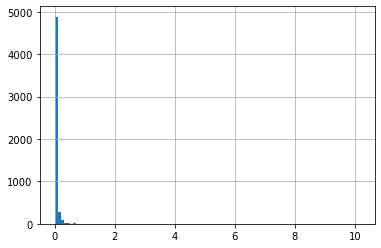

In [146]:
data_df.asym.hist(bins=100)

In [237]:
#colors=['Red' if c else 'Black' for c in data_df.group=='E.2']

# AF2 scores

In [8]:
# Group the data by 'group' and calculate the mean of 'pae_mean' and 'plddt' for each group
grouped_means = data_df.groupby('group')[['pae_mean', 'plddt', 'ptm']].mean().reset_index()

print(f'{len(grouped_means)} groups')

# Create a list with mean values for each group
mean_values_list = grouped_means.values.tolist()

data_grouped_df = pd.DataFrame(mean_values_list, columns=['group', 'pae_mean', 'plddt', 'ptm'])
data_grouped_df['size'] = data_df.groupby('group').size().tolist()


80 groups


In [9]:
data_grouped_df.sort_values(by='pae_mean', ascending=False).head(5)

,group,pae_mean,plddt,ptm,size
37,A.43,8.692899,72.587759,0.629167,12
59,E.2,6.248340,78.304191,0.695556,9
57,E.1,5.732185,81.567841,0.749677,62
73,F.7,5.061094,83.452227,0.750000,8
65,E.8,4.878387,84.587409,0.750000,7


In [10]:
data_grouped_df.sort_values(by='plddt', ascending=True).head(5)

,group,pae_mean,plddt,ptm,size
37,A.43,8.692899,72.587759,0.629167,12
59,E.2,6.248340,78.304191,0.695556,9
57,E.1,5.732185,81.567841,0.749677,62
73,F.7,5.061094,83.452227,0.750000,8
21,A.28,4.836333,84.095632,0.778288,146


In [48]:
paper2group['E.2']

'E_group_4'

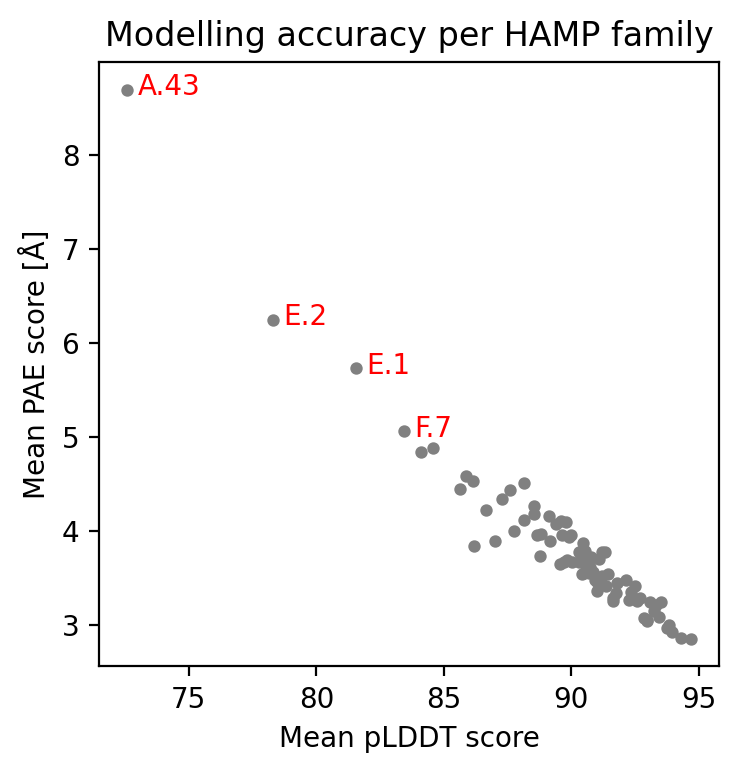

In [47]:
title_font_size = 12
label_font_size = 10

# Sort the DataFrame by 'pae_mean' in descending order and 'plddt' in ascending order
sorted_df = data_grouped_df.sort_values(by=['pae_mean', 'plddt'], ascending=[False, True])

# Get the top 3 groups
top_3_groups = sorted_df.head(4)

# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200, sharex=True)
ax.scatter(data_grouped_df.plddt, data_grouped_df.pae_mean, zorder=0, s=12, c='Grey')

# Add text labels for the top 3 groups
for index, row in top_3_groups.iterrows():
    ax.annotate(row['group'], (row['plddt'] + 0.4, row['pae_mean'] - 0.12), fontsize=10, ha='left', va='bottom', color='red')

# Set labels and title for the plot
ax.set_xlabel('Mean pLDDT score', fontsize=label_font_size)
ax.set_ylabel('Mean PAE score [Å]', fontsize=label_font_size)
ax.set_title('Modelling accuracy per HAMP family', fontsize=title_font_size)

# Show the plot
plt.show()


Text(0.5, 0, 'sequence count')

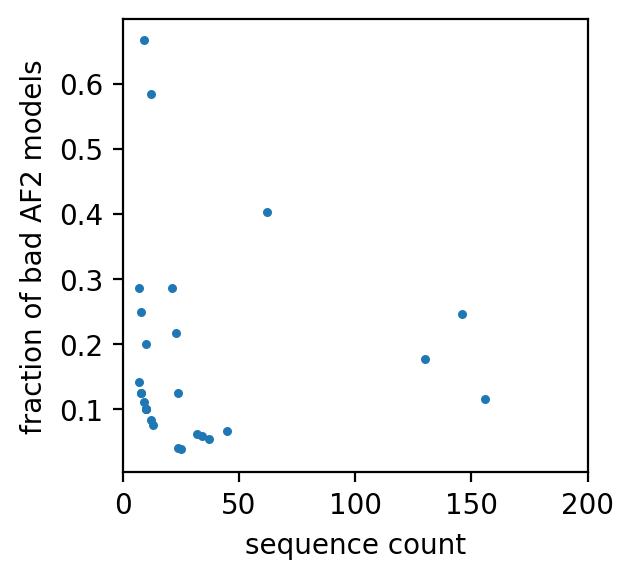

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)


pd.merge(
    data_df.group.value_counts(), x, how='left', left_index=True, right_index=True
           ).plot.scatter('group_x', 'group_y', ax=ax, s=5)

ax.set_xlim(0,200)
ax.set_ylabel('fraction of bad AF2 models')
ax.set_xlabel('sequence count')

E.2     0.666667
A.43    0.583333
E.1     0.403226
E.8     0.285714
E.7     0.285714
E.3     0.250000
Name: group, dtype: float64

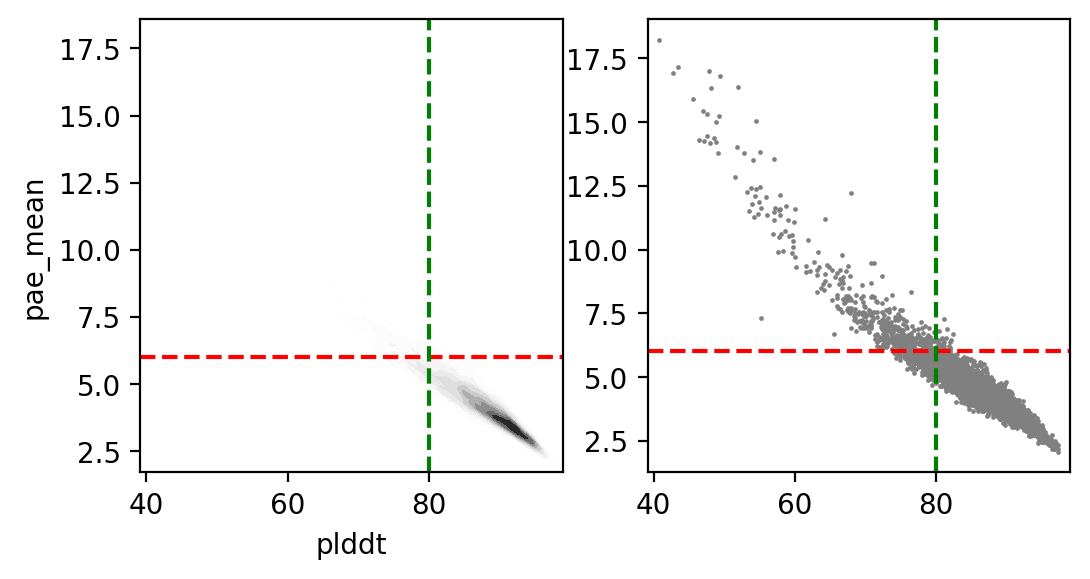

In [15]:


plddt_cut = 80
pae_mean_cut = 6

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True)

ax1 = axes[0]
ax2 = axes[1]

sns.kdeplot(data=data_df, x='plddt', y='pae_mean', fill=True, cmap='Greys', ax=ax1, bw_method=0.08)

ax2.scatter(data_df.plddt, data_df.pae_mean, zorder=0, s=0.5, c='Grey')

for ax in [ax1, ax2]:

    # Add horizontal and vertical lines
    ax.axhline(y=pae_mean_cut, color='red', linestyle='--', label='Horizontal Line at y=6')
    ax.axvline(x=plddt_cut, color='green', linestyle='--', label='Vertical Line at x=80')


x=(data_df[(data_df.plddt <= plddt_cut) & (data_df.pae_mean >= pae_mean_cut)].group.value_counts() / data_df.group.value_counts()).dropna().sort_values(ascending=False)
x[:6]


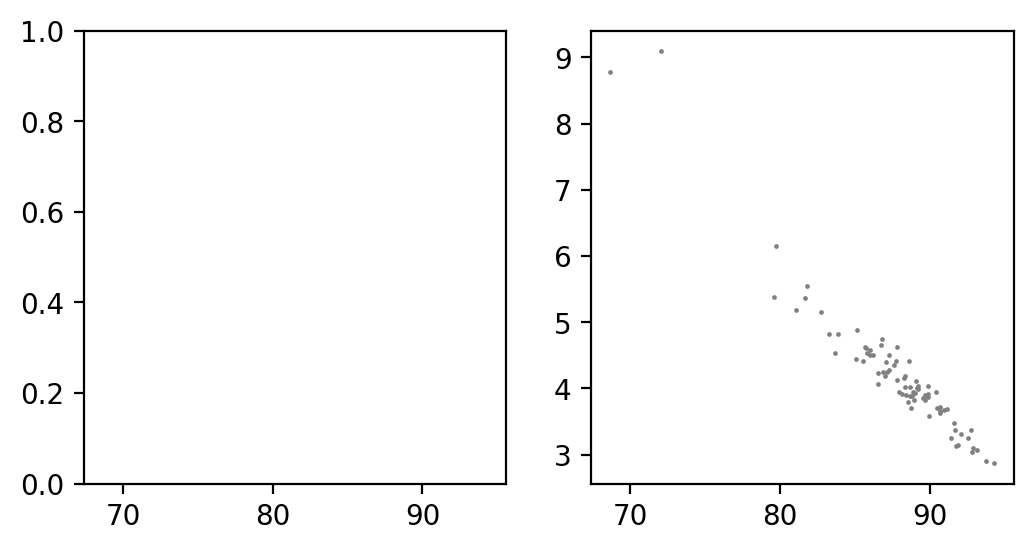

In [208]:
# https://www.ncbi.nlm.nih.gov/protein/YP_001760340.1?report=fasta # E1 # E2
# https://www.ncbi.nlm.nih.gov/protein/ZP_01998985.1?report=fasta # F7


Text(0.5, 0, 'sequence count')

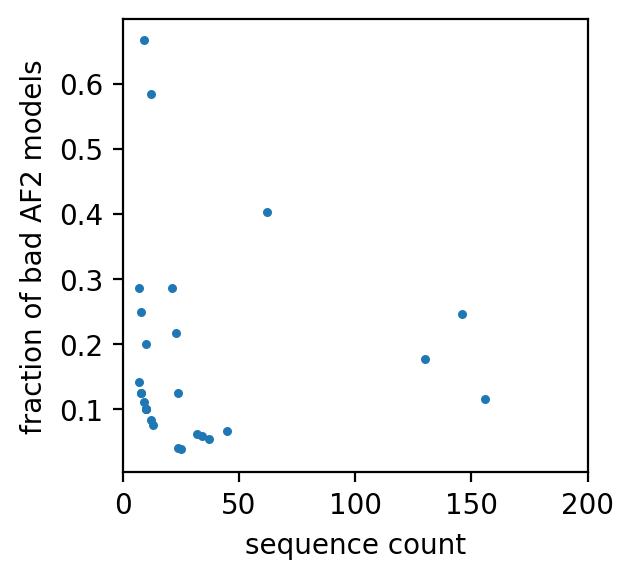

In [230]:
data_df[data_df.group=='E.1']

,group,n_rot,c_rot,rot,n_seq,c_seq,n_crick_mut,c_crick_mut,full_seq,pdb_file,max_pae,plddt,ptm,pae_mean,asym
idx,,,,,,,,,,,,,,,
6268,E.1,22.237017,5.581281,16.655736,EPAVLNEITRKIS,PKGSVFESMAAMQ,"[55.00002735096564, 55.25126655948548, 154.853...","[164.68746248073953, 164.47904912725284, -126....",KALGTEPAVLNEITRKISAGDLAPIPLAQAAPKGSVFESMAAMQQS...,1808/hamp_1808_relaxed_rank_1_model_3.pdb,31.75,73.740865,0.65,6.440876,0.185208
6267,E.1,-0.296160,33.640113,-33.936273,EPGQLGTVAQRVA,PRGSVLASLGAMQ,"[17.143580184545993, 16.94841113816554, 121.92...","[158.56900029823814, 158.7208717585301, -120.0...",RALGAEPGQLGTVAQRVAQGDLSRVDGAADAPRGSVLASLGAMQAS...,1809/hamp_1809_relaxed_rank_1_model_2.pdb,31.75,84.750962,0.75,4.299061,0.069475
6258,E.1,-13.467002,19.899271,-33.366274,EPSVAQHAAAQIA,DSSSLMSSLDAMR,"[6.977223483347891, 7.166346899838016, 119.121...","[20.61928988890213, -161.6120128205636, 106.02...",RQLGGEPSVAQHAAAQIADGNLMIDLPVAHGDSSSLMSSLDAMRAR...,1810/hamp_1810_relaxed_rank_1_model_4.pdb,31.75,85.625192,0.81,5.513534,0.063133
5472,E.1,2.049084,4.858050,-2.808967,EPTAIADIANKLA,AETGVYAAMHNMV,"[24.033324803574605, 24.20739981825064, 125.77...","[109.49521003642347, 109.33523328563592, -54.0...",RQLGGEPTAIADIANKLADGDLRIAFDTTGKAETGVYAAMHNMVEK...,1811/hamp_1811_relaxed_rank_1_model_2.pdb,31.75,74.321731,0.69,7.332439,0.065107
5456,E.1,-4.072221,1.632634,-5.704855,EPQAATEIMQRVA,PAGSLLHALGTMV,"[18.107296431929463, 18.02453239199886, 120.06...","[171.8193754477148, 171.85333458793914, -127.8...",RQLGGEPQAATEIMQRVAGGDLTARLDNAPAGSLLHALGTMVGSLR...,1812/hamp_1812_relaxed_rank_1_model_2.pdb,31.75,81.230600,0.73,5.657957,0.057544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,E.1,-10.824706,-7.459836,-3.364870,SPEYAKAIVHATA,DSDSLIAGIADMQ,"[10.573660739775573, 10.867865092240976, 116.0...","[15.810179901532392, 16.525014460000936, 108.6...",RMLGGSPEYAKAIVHATATGDLSIGIARHPNDSDSLIAGIADMQAR...,1876/hamp_1876_relaxed_rank_1_model_2.pdb,31.75,88.604327,0.84,4.146109,0.050868
1824,E.1,-25.345750,-3.604211,-21.741539,DPQDTVAVVKRIA,DGDSLMSAVGAMQ,"[1.1860298819690078, 1.2132721088346938, 104.3...","[23.34465910441432, 23.229259629418976, 117.93...",SQLGGDPQDTVAVVKRIAAGHLDEEVAVKEGDGDSLMSAVGAMQRE...,1877/hamp_1877_relaxed_rank_1_model_1.pdb,31.75,84.998269,0.79,5.338663,0.062582
1823,E.1,-7.905259,25.727888,-33.633147,EPYIASYIVSKIA,NKDSILSSIASMQ,"[17.54912590136121, 18.336034618605083, 118.93...","[-170.84628342801614, -170.70905403239973, -70...",RLLGGEPYIASYIVSKIANGDLSGHITYKNKDSILSSIASMQEGLR...,1878/hamp_1878_relaxed_rank_1_model_2.pdb,31.75,79.204300,0.69,6.033646,0.082649


In [136]:
from Bio import SeqIO

In [137]:
# read and cluster sequences from https://pubmed.ncbi.nlm.nih.gov/20184894/
msa = list(SeqIO.parse(os.path.join(data_dir, 'hamp_msa.fasta'), 'fasta'))

msa_df = pd.DataFrame(
        [(str(i.seq).replace('-', ''), i.id) for i in msa],
    columns=['sequence', 'id']
)

In [151]:
msa_df.loc[2048]

sequence    DELTDSFRKLEVFAEEVGTGNFDTDIQVFDEEGDVGQSLAKMQNSL...
id                           5439|E_group_4|gi|124008109|HAMP
Name: 2048, dtype: object

In [109]:
get_asymmetry(
       os.path.join(data_dir, 'af2_full', '2956/hamp_2956_relaxed_rank_1_model_4.pdb') 
)

(0.07056385735691044, 0.13442089)